In [1]:
# from google.colab import drive
# drive.mount('/content/gdrive')
!pip install pyPDF2

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 232.6/232.6 kB 1.8 MB/s eta 0:00:00a 0:00:01


In [47]:
from keras.callbacks import EarlyStopping,ReduceLROnPlateau,ModelCheckpoint,TensorBoard,LambdaCallback
from keras.layers import Lambda, SeparableConv2D, GlobalAvgPool2D, Input, Average, ReLU, Dropout, DepthwiseConv2D, Dense, GlobalAvgPool2D, GlobalAveragePooling2D,Conv2D, ZeroPadding2D, BatchNormalization, Activation, MaxPooling2D, Flatten, AvgPool2D, Concatenate, MaxPool2D
from keras.layers import Concatenate, Add, Dropout, ReLU, Lambda, Activation, LeakyReLU, PReLU


from keras.preprocessing import image

from glob import glob

from IPython.display import SVG
# from keras.utils.vis_utils import model_to_dot
from keras.models import Sequential,Model
import pandas as pd
# from keras.applications.resnet import ResNet50

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix,classification_report
from sklearn.utils import shuffle
import matplotlib.pyplot as plt
from tensorflow import keras
import tensorflow as tf
from tqdm import tqdm
import seaborn as sns
import numpy as np
import itertools
import time
import datetime
import os
import cv2
import io

# import imutils
import matplotlib.pyplot as plt
from os import listdir

from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler

from sklearn.cluster import KMeans

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

%matplotlib inline

In [3]:
# Set the path to the dataset
# dataset_path = "C:/Users/USER/ML/Latest/def_data"
dataset_path = "/kaggle/input/brain-tumor-mri-dataset"

# Define the training and testing directories
train_dir = os.path.join(dataset_path, "/kaggle/input/brain-tumor-mri-dataset/Training")
test_dir = os.path.join(dataset_path, "/kaggle/input/brain-tumor-mri-dataset/Testing")

# Define the categories
categories = ["glioma", "meningioma", "notumor", "pituitary"]

1321
1339
1595
1457


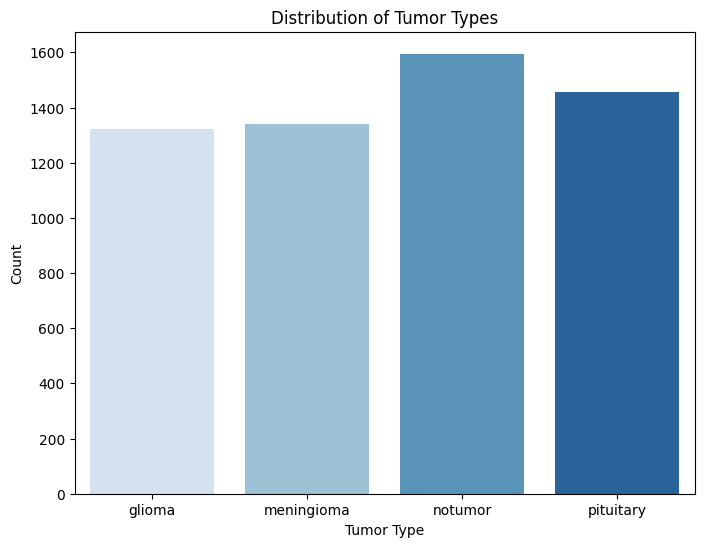

In [4]:
# Load and preprocess the dataset
train_data = []
for category in categories:
    folder_path = os.path.join(train_dir, category)
    images = os.listdir(folder_path)
    count = len(images)
    print(count)
    train_data.append(pd.DataFrame({"Image": images, "Category": [category] * count, "Count": [count] * count}))

train_df = pd.concat(train_data, ignore_index=True)

# Visualize the distribution of tumor types in the training dataset
plt.figure(figsize=(8, 6))
sns.barplot(data=train_df, x="Category", y="Count", palette = "Blues")#######, legend=False
plt.title("Distribution of Tumor Types")
plt.xlabel("Tumor Type")
plt.ylabel("Count")
plt.show()

300
306
405
300


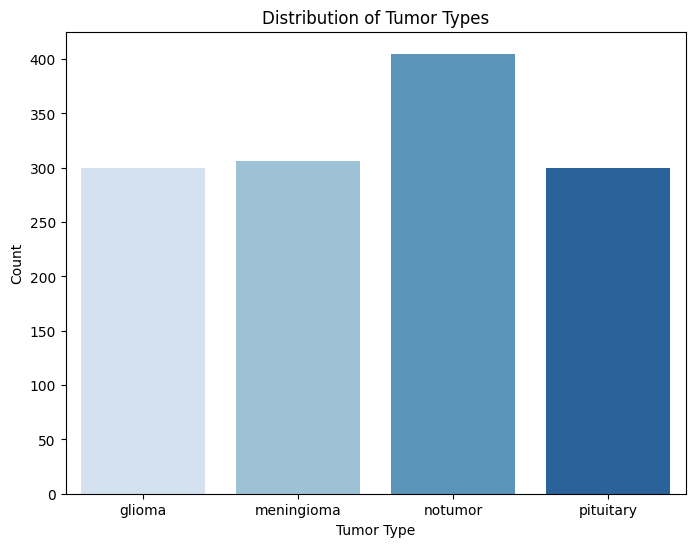

In [5]:
# Load and preprocess the dataset
test_data = []
for category in categories:
    folder_path = os.path.join(test_dir, category)
    images = os.listdir(folder_path)
    count = len(images)
    print(count)
    test_data.append(pd.DataFrame({"Image": images, "Category": [category] * count, "Count": [count] * count}))

test_df = pd.concat(test_data, ignore_index=True)

# Visualize the distribution of tumor types in the training dataset
plt.figure(figsize=(8, 6))
sns.barplot(data=test_df, x="Category", y="Count", palette = "Blues")
plt.title("Distribution of Tumor Types")
plt.xlabel("Tumor Type")
plt.ylabel("Count")
plt.show()

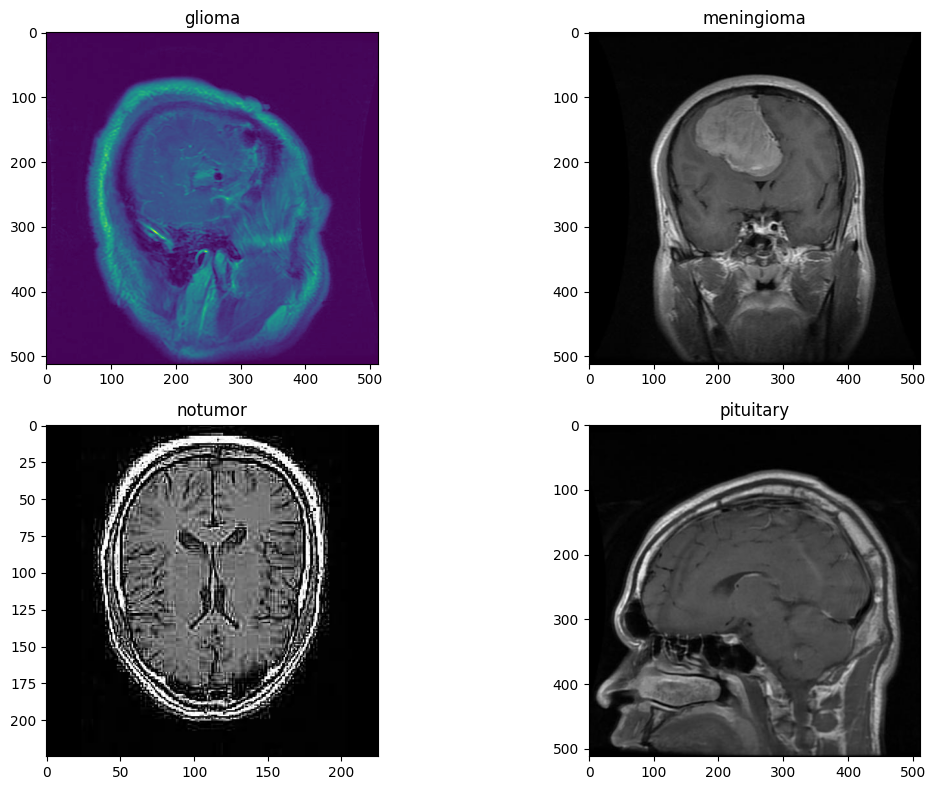

In [6]:
# Visualize sample images for each tumor type
plt.figure(figsize=(12, 8))
for i, category in enumerate(categories):
    folder_path = os.path.join(train_dir, category)
    image_path = os.path.join(folder_path, os.listdir(folder_path)[0])
    img = plt.imread(image_path)
    plt.subplot(2, 2, i+1)
    plt.imshow(img)
    plt.title(category)
    plt.axis("on")
plt.tight_layout()
plt.show()

In [7]:
# Set the image size
image_size = (150, 150)

# Set the batch size for training
batch_size = 32

# Set the number of epochs for training
epochs = 50

In [8]:
# Data augmentation and preprocessing
from keras.preprocessing.image import ImageDataGenerator
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode="nearest"
)

train_set = train_datagen.flow_from_directory(
    train_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode="categorical"
)

test_datagen = ImageDataGenerator(rescale=1./255)

test_set = test_datagen.flow_from_directory(
    test_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode="categorical",
    shuffle=False
)

Found 5712 images belonging to 4 classes.
Found 1311 images belonging to 4 classes.


In [13]:
def xception(input_shape, n_classes):

  def conv_bn(x, f, k, s=1, p='same'):
    x = Conv2D(f, k, strides=s, padding=p, use_bias=False)(x)
    x = BatchNormalization()(x)
    return x


  def sep_bn(x, f, k, s=1, p='same'):
    x = SeparableConv2D(f, k, strides=s, padding=p, use_bias=False)(x)
    x = BatchNormalization()(x)
    return x


  def entry_flow(x):
    x = conv_bn(x, 32, 3, 2)
    x = ReLU()(x)
    x = conv_bn(x, 64, 3)
    tensor = ReLU()(x)

    x = sep_bn(tensor, 128, 3)
    x = ReLU()(x)
    x = sep_bn(x, 128, 3)
    x = MaxPool2D(3, strides=2, padding='same')(x)

    tensor = conv_bn(tensor, 128, 1, 2)

    x = Add()([tensor, x])
    x = ReLU()(x)
    x = sep_bn(x, 256, 3)
    x = ReLU()(x)
    x = sep_bn(x, 256, 3)
    x = MaxPool2D(3, strides=2, padding='same')(x)

    tensor = conv_bn(tensor, 256, 1, 2)

    x = Add()([tensor, x])
    x = ReLU()(x)
    x = sep_bn(x, 728, 3)
    x = ReLU()(x)
    x = sep_bn(x, 728, 3)
    x = MaxPool2D(3, strides=2, padding='same')(x)

    tensor = conv_bn(tensor, 728, 1, 2)
    x = Add()([tensor, x])

    return x


  def middle_flow(tensor):
    for _ in range(8):
      x = ReLU()(tensor)
      x = sep_bn(x, 728, 3)
      x = ReLU()(x)
      x = sep_bn(x, 728, 3)
      x = ReLU()(x)
      x = sep_bn(x, 728, 3)

      tensor = Add()([tensor, x])

    return tensor


  def exit_flow(tensor):
    x = ReLU()(tensor)
    x = sep_bn(x, 728, 3)
    x = ReLU()(x)
    x = sep_bn(x, 1024, 3)
    x = MaxPool2D(3, strides=2, padding='same')(x)

    tensor = conv_bn(tensor, 1024, 1, 2)

    x = Add()([tensor, x])
    x = sep_bn(x, 1536, 3)
    x = ReLU()(x)
    x = sep_bn(x, 2048, 3)
    x = ReLU()(x)
    x = GlobalAvgPool2D()(x)
    x = Dense(n_classes, activation='softmax')(x)

    return x


  input = Input(input_shape)

  x = entry_flow(input)
  x = middle_flow(x)
  output = exit_flow(x)

  model = Model(input, output)

  return model

In [14]:
IMG_SHAPE = (150, 150, 3)

In [15]:
xception_model = xception(IMG_SHAPE, 4)

In [16]:
xception_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 150, 150, 3)]        0         []                            
                                                                                                  
 conv2d_2 (Conv2D)           (None, 75, 75, 32)           864       ['input_2[0][0]']             
                                                                                                  
 batch_normalization_2 (Bat  (None, 75, 75, 32)           128       ['conv2d_2[0][0]']            
 chNormalization)                                                                                 
                                                                                                  
 re_lu_2 (ReLU)              (None, 75, 75, 32)           0         ['batch_normalization_2[0]

In [17]:
from keras.applications.inception_v3 import InceptionV3
InceptionV3 = InceptionV3(input_shape=(150, 150, 3),
            weights='imagenet',
            include_top=False)

87910968/87910968 [==============================] - 0s 0us/step


In [18]:
for layer in InceptionV3.layers:
    layer.trainable = False

In [19]:
folders = glob('/kaggle/input/brain-tumor-mri-dataset/Training/*')
print(len(folders))

4


In [20]:
x = InceptionV3.output
x = GlobalAveragePooling2D()(x)
# x = Dropout(0.4)(x)
x = Flatten()(x)
x = Dense(1024, activation='relu')(x)
prediction = Dense(len(folders), activation='softmax')(x)
InceptionV3_model = Model(inputs=InceptionV3.input, outputs=prediction)

In [21]:
InceptionV3_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 150, 150, 3)]        0         []                            
                                                                                                  
 conv2d_8 (Conv2D)           (None, 74, 74, 32)           864       ['input_3[0][0]']             
                                                                                                  
 batch_normalization_42 (Ba  (None, 74, 74, 32)           96        ['conv2d_8[0][0]']            
 tchNormalization)                                                                                
                                                                                                  
 activation (Activation)     (None, 74, 74, 32)           0         ['batch_normalization_42

In [22]:
from datetime import datetime
from keras.callbacks import ModelCheckpoint
checkpoint = ModelCheckpoint(filepath='Ensemble_kaggke_Xception_InceptionV3.h5',
                             mode='max',
                             verbose=2,
                             save_best_only=True)
callbacks = [checkpoint]
start = datetime.now()

In [23]:
xception_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [24]:
# adam = keras.optimizers.Adam(learning_rate=0.001)
InceptionV3_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [25]:
# Train the model
history_xception_model = xception_model.fit(
    train_set,
    steps_per_epoch=train_set.samples // batch_size,
    epochs=epochs,
    validation_data=test_set,
    validation_steps=test_set.samples // batch_size
)

Epoch 1/50


I0000 00:00:1707777278.997354     123 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


178/178 [==============================] - 116s 464ms/step - loss: 0.8901 - accuracy: 0.6511 - val_loss: 1.3918 - val_accuracy: 0.2398
Epoch 2/50
178/178 [==============================] - 50s 280ms/step - loss: 0.6132 - accuracy: 0.7664 - val_loss: 1.8412 - val_accuracy: 0.3125
Epoch 3/50
178/178 [==============================] - 49s 276ms/step - loss: 0.4492 - accuracy: 0.8299 - val_loss: 1.6493 - val_accuracy: 0.5508
Epoch 4/50
178/178 [==============================] - 51s 283ms/step - loss: 0.3299 - accuracy: 0.8819 - val_loss: 70.2245 - val_accuracy: 0.3352
Epoch 5/50
178/178 [==============================] - 51s 283ms/step - loss: 0.2995 - accuracy: 0.8940 - val_loss: 13.5219 - val_accuracy: 0.5766
Epoch 6/50
178/178 [==============================] - 50s 282ms/step - loss: 0.2765 - accuracy: 0.9051 - val_loss: 210.9185 - val_accuracy: 0.3164
Epoch 7/50
178/178 [==============================] - 50s 281ms/step - loss: 0.2453 - accuracy: 0.9085 - val_loss: 0.8469 - val_accuracy

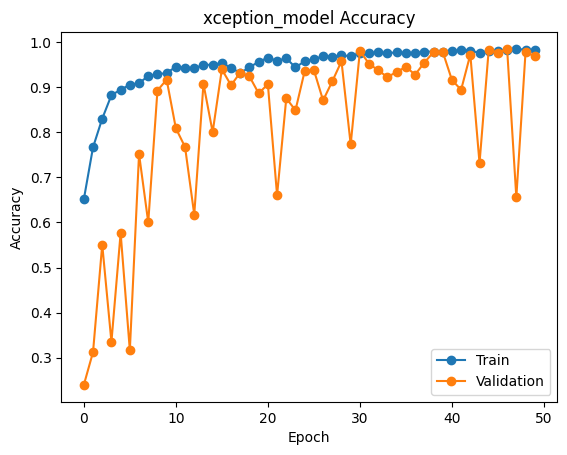

In [26]:
# Plot the training and validation accuracy over epochs
plt.plot(history_xception_model.history['accuracy'], '-o')
plt.plot(history_xception_model.history['val_accuracy'], '-o')
plt.title('xception_model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'])
plt.show()

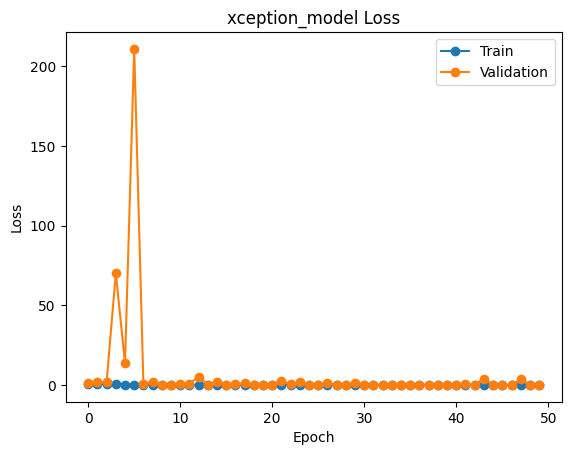

In [27]:
# Plot the training and validation loss over epochs
plt.plot(history_xception_model.history['loss'], '-o')
plt.plot(history_xception_model.history['val_loss'], '-o')
plt.title('xception_model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'])
plt.show()

In [29]:
# Evaluate the model
loss_xception_model, accuracy_xception_model = xception_model.evaluate(test_set, steps=test_set.samples // batch_size)
# loss, accuracy = model.evaluate(test_set, steps=32)

print("xception_model Test Loss:", loss_xception_model)
print("xception_model Test Accuracy:", accuracy_xception_model)

40/40 [==============================] - 4s 85ms/step - loss: 0.1054 - accuracy: 0.9680
xception_model Test Loss: 0.10541460663080215
xception_model Test Accuracy: 0.967968761920929


41/41 [==============================] - 3s 73ms/step
[0 0 0 ... 3 3 3]


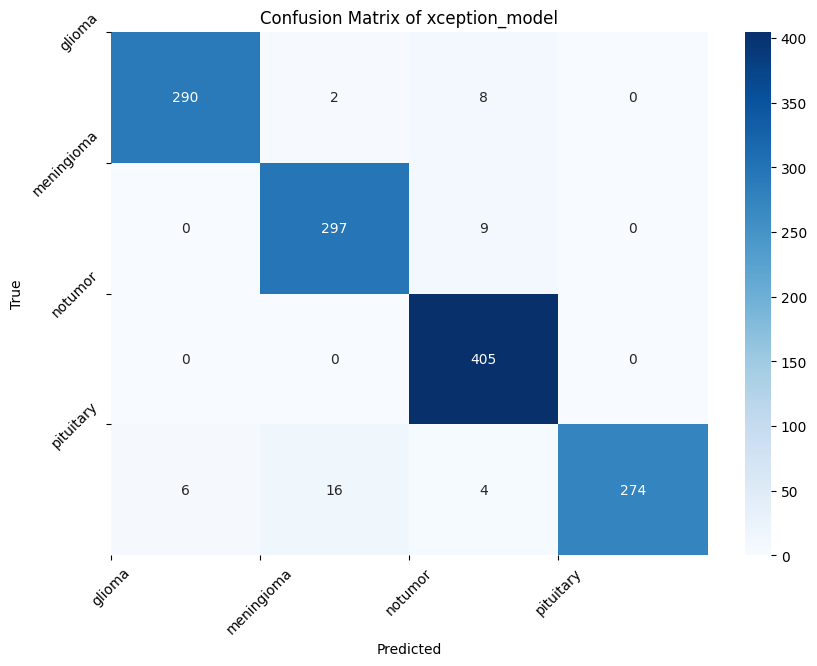

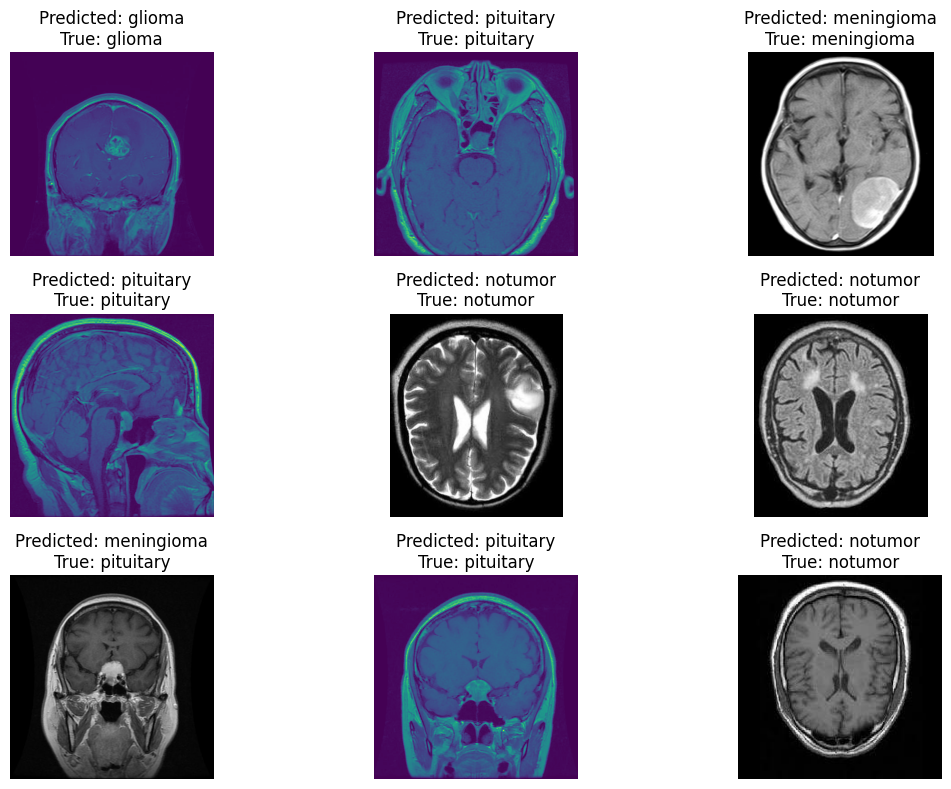

In [35]:
# Make predictions on the test dataset
predictions_xception_model = xception_model.predict(test_set)
predicted_categories_xception_model = np.argmax(predictions_xception_model, axis=1)

true_categories_xception_model = test_set.classes
print(true_categories_xception_model)

# Create a confusion matrix
confusion_matrix_xception_model = tf.math.confusion_matrix(true_categories_xception_model, predicted_categories_xception_model)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix_xception_model, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix of xception_model")
plt.tight_layout() #########
plt.xlabel("Predicted")
plt.ylabel("True")
plt.xticks(ticks=np.arange(len(categories)), labels=categories, rotation=45)
plt.yticks(ticks=np.arange(len(categories)), labels=categories, rotation=45)
plt.show()

# Plot sample images with their predicted and true labels
test_images = test_set.filenames
sample_indices = np.random.choice(range(len(test_images)), size=9, replace=False)
# print(sample_indices)
sample_images = [test_images[i] for i in sample_indices]
sample_predictions_xception_model = [categories[predicted_categories_xception_model[i]] for i in sample_indices]
sample_true_labels_xception_model = [categories[true_categories_xception_model[i]] for i in sample_indices]

plt.figure(figsize=(12, 8))
for i in range(9):
    plt.subplot(3, 3, i+1)
    img = plt.imread(os.path.join(test_dir, sample_images[i]))
    plt.imshow(img)
    plt.title(f"Predicted: {sample_predictions_xception_model[i]}\nTrue: {sample_true_labels_xception_model[i]}")
    plt.axis("off")
plt.tight_layout()
plt.show()

Class: glioma
Precision: 0.9797297297297297
Recall: 0.9666666666666667
F1-Score: 0.9731543624161074

Class: meningioma
Precision: 0.9428571428571428
Recall: 0.9705882352941176
F1-Score: 0.9565217391304348

Class: notumor
Precision: 0.9507042253521126
Recall: 1.0
F1-Score: 0.9747292418772564

Class: pituitary
Precision: 1.0
Recall: 0.9133333333333333
F1-Score: 0.9547038327526133



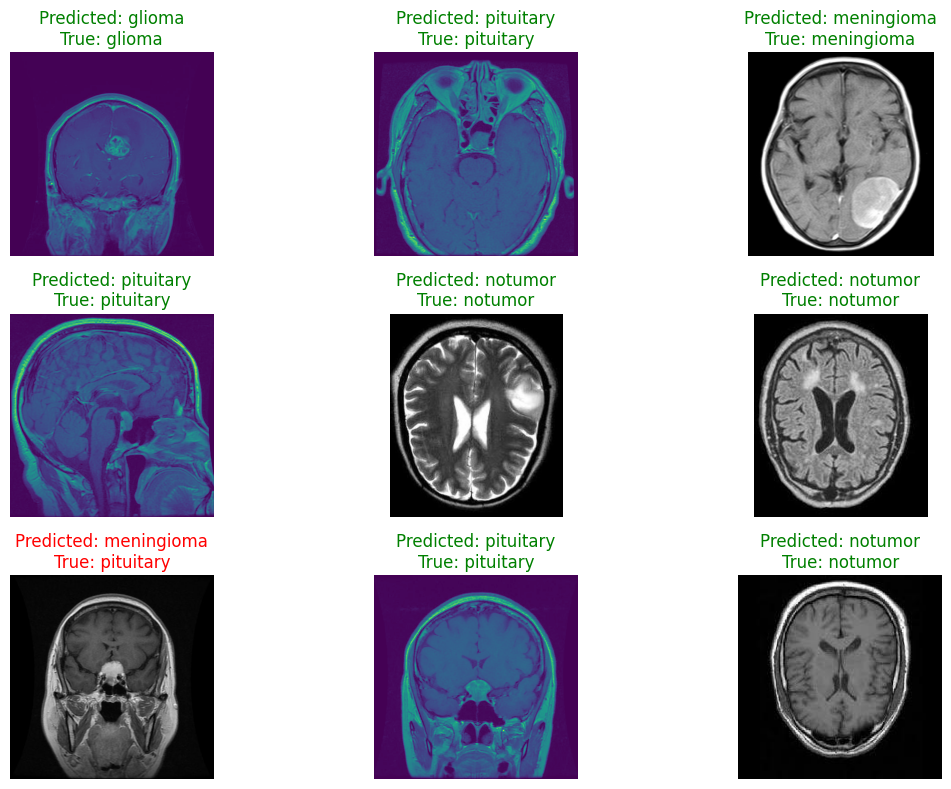

In [36]:
# Calculate precision, recall, and F1-score from the confusion matrix
precision_xception_model = np.diag(confusion_matrix_xception_model) / np.sum(confusion_matrix_xception_model, axis=0)
recall_xception_model = np.diag(confusion_matrix_xception_model) / np.sum(confusion_matrix_xception_model, axis=1)
f1_score_xception_model = 2 * (precision_xception_model * recall_xception_model) / (precision_xception_model + recall_xception_model)

# Print precision, recall, and F1-score for each class
for i, category in enumerate(categories):
    print(f"Class: {category}")
    print(f"Precision: {precision_xception_model[i]}")
    print(f"Recall: {recall_xception_model[i]}")
    print(f"F1-Score: {f1_score_xception_model[i]}")
    print()

# Analyze the sample images and their predictions
plt.figure(figsize=(12, 8))
for i in range(9):
    plt.subplot(3, 3, i+1)
    img = plt.imread(os.path.join(test_dir, sample_images[i]))
    plt.imshow(img)
    if sample_predictions_xception_model[i] == sample_true_labels_xception_model[i]:
        plt.title(f"Predicted: {sample_predictions_xception_model[i]}\nTrue: {sample_true_labels_xception_model[i]}", color='green')
    else:
        plt.title(f"Predicted: {sample_predictions_xception_model[i]}\nTrue: {sample_true_labels_xception_model[i]}", color='red')
    plt.axis("off")
plt.tight_layout()
plt.show()

In [37]:
# Save the trained model
xception_model.save("Xception_model_brain_tumor_detection_model.h5")

/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [38]:
# history = model.fit_generator(
history_InceptionV3_model = InceptionV3_model.fit(
    train_set,
    validation_data=test_set,
    epochs=epochs,
    steps_per_epoch=train_set.samples // batch_size,
    validation_steps=test_set.samples // batch_size,
    callbacks=callbacks,
    verbose=2)
duration = datetime.now() - start
print("Training completed in time: ", duration)

Epoch 1/50

Epoch 1: val_loss did not improve from 0.67159
178/178 - 46s - loss: 0.3679 - accuracy: 0.8625 - val_loss: 0.4309 - val_accuracy: 0.8352 - 46s/epoch - 261ms/step
Epoch 2/50

Epoch 2: val_loss did not improve from 0.67159
178/178 - 47s - loss: 0.3546 - accuracy: 0.8641 - val_loss: 0.4748 - val_accuracy: 0.8164 - 47s/epoch - 263ms/step
Epoch 3/50

Epoch 3: val_loss did not improve from 0.67159
178/178 - 46s - loss: 0.3581 - accuracy: 0.8657 - val_loss: 0.3646 - val_accuracy: 0.8578 - 46s/epoch - 259ms/step
Epoch 4/50

Epoch 4: val_loss did not improve from 0.67159
178/178 - 46s - loss: 0.3306 - accuracy: 0.8743 - val_loss: 0.3908 - val_accuracy: 0.8555 - 46s/epoch - 259ms/step
Epoch 5/50

Epoch 5: val_loss did not improve from 0.67159
178/178 - 46s - loss: 0.3045 - accuracy: 0.8826 - val_loss: 0.3524 - val_accuracy: 0.8625 - 46s/epoch - 256ms/step
Epoch 6/50

Epoch 6: val_loss did not improve from 0.67159
178/178 - 46s - loss: 0.2928 - accuracy: 0.8919 - val_loss: 0.4079 - va

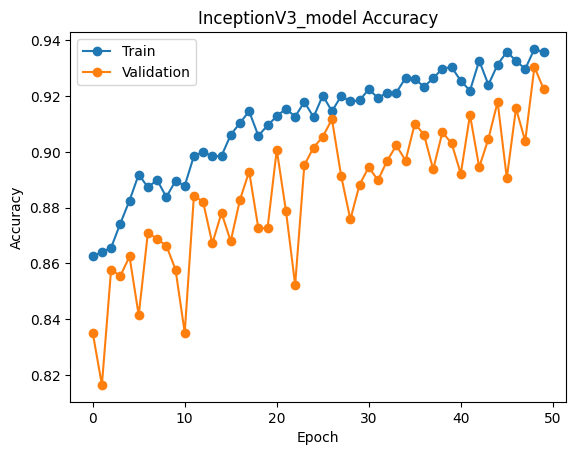

In [39]:
# Plot the training and validation accuracy over epochs
plt.plot(history_InceptionV3_model.history['accuracy'], '-o')
plt.plot(history_InceptionV3_model.history['val_accuracy'], '-o')
plt.title('InceptionV3_model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'])
plt.show()

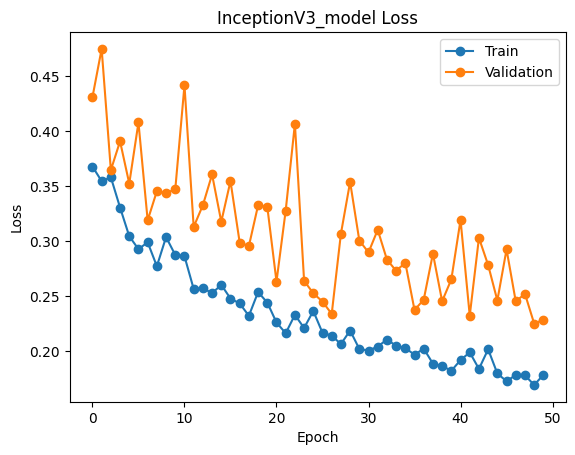

In [40]:
# Plot the training and validation loss over epochs
plt.plot(history_InceptionV3_model.history['loss'], '-o')
plt.plot(history_InceptionV3_model.history['val_loss'], '-o')
plt.title('InceptionV3_model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'])
plt.show()

In [41]:
# Evaluate the model
loss_InceptionV3_model, accuracy_InceptionV3_model = InceptionV3_model.evaluate(test_set, steps=test_set.samples // batch_size)
# loss, accuracy = model.evaluate(test_set, steps=32)

print("InceptionV3_model Test Loss:", loss_InceptionV3_model)
print("InceptionV3_model Test Accuracy:", accuracy_InceptionV3_model)

40/40 [==============================] - 3s 69ms/step - loss: 0.2286 - accuracy: 0.9227
InceptionV3_model Test Loss: 0.22856441140174866
InceptionV3_model Test Accuracy: 0.922656238079071


41/41 [==============================] - 7s 136ms/step
[0 0 0 ... 3 3 3]


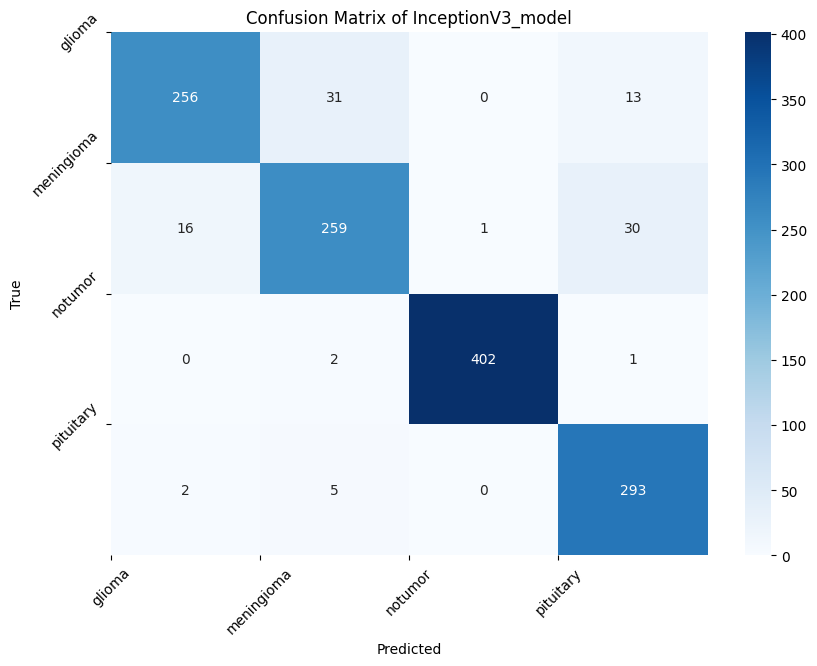

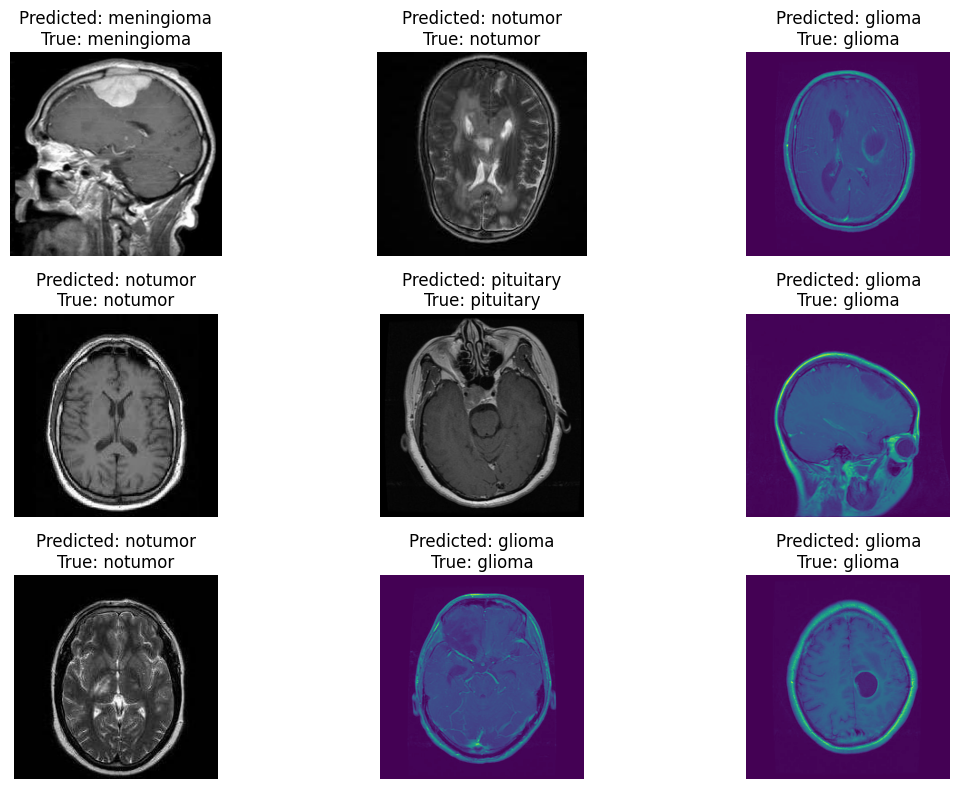

In [42]:
# Make predictions on the test dataset
predictions_InceptionV3_model = InceptionV3_model.predict(test_set)
predicted_categories_InceptionV3_model = np.argmax(predictions_InceptionV3_model, axis=1)

true_categories_InceptionV3_model = test_set.classes
print(true_categories_InceptionV3_model)

# Create a confusion matrix
confusion_matrix_InceptionV3_model = tf.math.confusion_matrix(true_categories_InceptionV3_model, predicted_categories_InceptionV3_model)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix_InceptionV3_model, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix of InceptionV3_model")
plt.tight_layout() #########
plt.xlabel("Predicted")
plt.ylabel("True")
plt.xticks(ticks=np.arange(len(categories)), labels=categories, rotation=45)
plt.yticks(ticks=np.arange(len(categories)), labels=categories, rotation=45)
plt.show()

# Plot sample images with their predicted and true labels
test_images = test_set.filenames
sample_indices = np.random.choice(range(len(test_images)), size=9, replace=False)
# print(sample_indices)
sample_images = [test_images[i] for i in sample_indices]
sample_predictions_InceptionV3_model = [categories[predicted_categories_InceptionV3_model[i]] for i in sample_indices]
sample_true_labels_InceptionV3_model = [categories[true_categories_InceptionV3_model[i]] for i in sample_indices]

plt.figure(figsize=(12, 8))
for i in range(9):
    plt.subplot(3, 3, i+1)
    img = plt.imread(os.path.join(test_dir, sample_images[i]))
    plt.imshow(img)
    plt.title(f"Predicted: {sample_predictions_InceptionV3_model[i]}\nTrue: {sample_true_labels_InceptionV3_model[i]}")
    plt.axis("off")
plt.tight_layout()
plt.show()

Class: glioma
Precision: 0.9343065693430657
Recall: 0.8533333333333334
F1-Score: 0.89198606271777

Class: meningioma
Precision: 0.8720538720538721
Recall: 0.8464052287581699
F1-Score: 0.8590381426202321

Class: notumor
Precision: 0.9975186104218362
Recall: 0.9925925925925926
F1-Score: 0.995049504950495

Class: pituitary
Precision: 0.8694362017804155
Recall: 0.9766666666666667
F1-Score: 0.9199372056514915



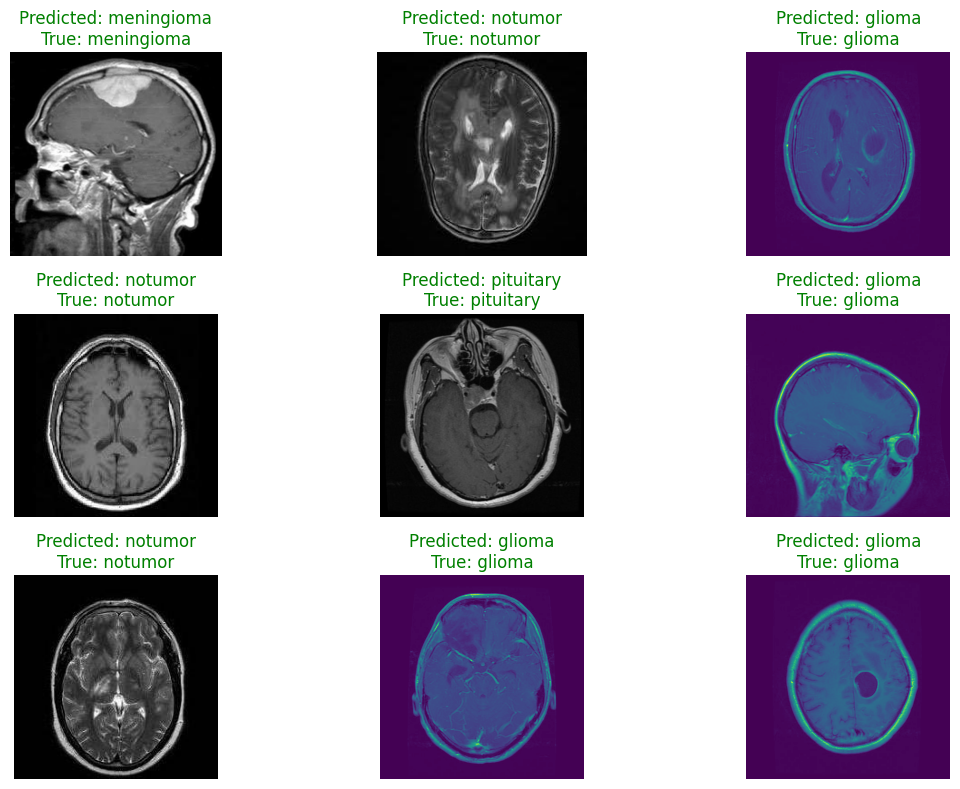

In [43]:
# Calculate precision, recall, and F1-score from the confusion matrix
precision_InceptionV3_model = np.diag(confusion_matrix_InceptionV3_model) / np.sum(confusion_matrix_InceptionV3_model, axis=0)
recall_InceptionV3_model = np.diag(confusion_matrix_InceptionV3_model) / np.sum(confusion_matrix_InceptionV3_model, axis=1)
f1_score_InceptionV3_model = 2 * (precision_InceptionV3_model * recall_InceptionV3_model) / (precision_InceptionV3_model + recall_InceptionV3_model)

# Print precision, recall, and F1-score for each class
for i, category in enumerate(categories):
    print(f"Class: {category}")
    print(f"Precision: {precision_InceptionV3_model[i]}")
    print(f"Recall: {recall_InceptionV3_model[i]}")
    print(f"F1-Score: {f1_score_InceptionV3_model[i]}")
    print()

# Analyze the sample images and their predictions
plt.figure(figsize=(12, 8))
for i in range(9):
    plt.subplot(3, 3, i+1)
    img = plt.imread(os.path.join(test_dir, sample_images[i]))
    plt.imshow(img)
    if sample_predictions_InceptionV3_model[i] == sample_true_labels_InceptionV3_model[i]:
        plt.title(f"Predicted: {sample_predictions_InceptionV3_model[i]}\nTrue: {sample_true_labels_InceptionV3_model[i]}", color='green')
    else:
        plt.title(f"Predicted: {sample_predictions_InceptionV3_model[i]}\nTrue: {sample_true_labels_InceptionV3_model[i]}", color='red')
    plt.axis("off")
plt.tight_layout()
plt.show()

In [44]:
# Save the trained model
InceptionV3_model.save("InceptionV3_model_brain_tumor_detection_model.h5")

/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [45]:
xception_model = Model(inputs=xception_model.inputs,
                       outputs=xception_model.outputs,
                       name='xception_model')

InceptionV3_model = Model(inputs=InceptionV3_model.inputs,
                       outputs=InceptionV3_model.outputs,
                       name='InceptionV3_model')

In [48]:
models = [xception_model, InceptionV3_model]
model_input = Input(shape = (150, 150, 3))
model_outputs = [model(model_input) for model in models]
Ensamble_output = Average()(model_outputs)
Ensamble_model = Model(inputs=model_input, outputs=Ensamble_output, name='Ensamble_model')

In [49]:
Ensamble_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [50]:
# Train the model
history_Ensamble_model = Ensamble_model.fit(
    train_set,
    steps_per_epoch=train_set.samples // batch_size,
    epochs=epochs,
    validation_data=test_set,
    validation_steps=test_set.samples // batch_size
)

Epoch 1/50
178/178 [==============================] - 85s 314ms/step - loss: 0.0774 - accuracy: 0.9845 - val_loss: 0.1829 - val_accuracy: 0.9438
Epoch 2/50
178/178 [==============================] - 52s 292ms/step - loss: 0.0862 - accuracy: 0.9840 - val_loss: 0.1215 - val_accuracy: 0.9727
Epoch 3/50
178/178 [==============================] - 52s 293ms/step - loss: 0.0825 - accuracy: 0.9831 - val_loss: 0.1472 - val_accuracy: 0.9609
Epoch 4/50
178/178 [==============================] - 52s 292ms/step - loss: 0.0749 - accuracy: 0.9845 - val_loss: 0.1061 - val_accuracy: 0.9742
Epoch 5/50
178/178 [==============================] - 53s 294ms/step - loss: 0.0818 - accuracy: 0.9817 - val_loss: 0.0851 - val_accuracy: 0.9750
Epoch 6/50
178/178 [==============================] - 52s 293ms/step - loss: 0.0865 - accuracy: 0.9815 - val_loss: 0.1698 - val_accuracy: 0.9492
Epoch 7/50
178/178 [==============================] - 52s 293ms/step - loss: 0.0796 - accuracy: 0.9840 - val_loss: 0.1648 - val_ac

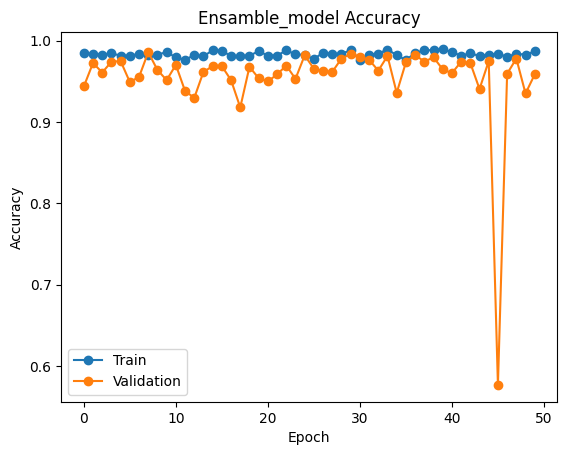

In [55]:
# Plot the training and validation accuracy over epochs
plt.plot(history_Ensamble_model.history['accuracy'], '-o')
plt.plot(history_Ensamble_model.history['val_accuracy'], '-o')
plt.title('Ensamble_model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
# axes = plt.axes()
# axes.set_ylim([0.9, 1])
plt.legend(['Train', 'Validation'])
plt.show()

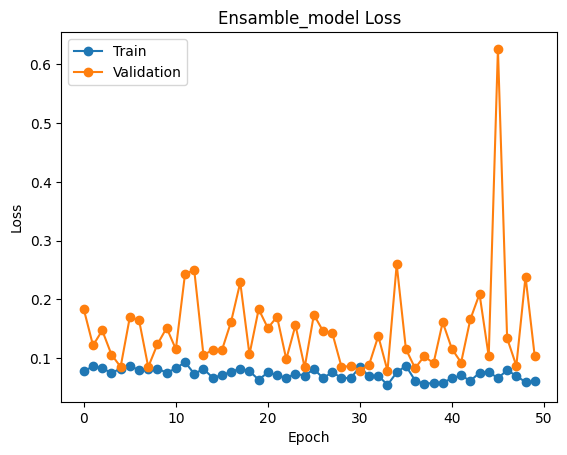

In [52]:
# Plot the training and validation loss over epochs
plt.plot(history_Ensamble_model.history['loss'], '-o')
plt.plot(history_Ensamble_model.history['val_loss'], '-o')
plt.title('Ensamble_model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'])
plt.show()

In [53]:
# Evaluate the model
loss_Ensamble_model, accuracy_Ensamble_model = Ensamble_model.evaluate(test_set, steps=test_set.samples // batch_size)
# loss, accuracy = model.evaluate(test_set, steps=32)

print("Ensamble_model Test Loss:", loss_Ensamble_model)
print("Ensamble_model Test Accuracy:", accuracy_Ensamble_model)

40/40 [==============================] - 4s 93ms/step - loss: 0.1030 - accuracy: 0.9586
Ensamble_model Test Loss: 0.1030137687921524
Ensamble_model Test Accuracy: 0.9585937261581421


In [ ]:
# Make predictions on the test dataset
predictions_Ensamble_model = Ensamble_model.predict(test_set)
predicted_categories_Ensamble_model = np.argmax(predictions_Ensamble_model, axis=1)

true_categories_Ensamble_model = test_set.classes
print(true_categories_Ensamble_model)

# Create a confusion matrix
confusion_matrix_Ensamble_model = tf.math.confusion_matrix(true_categories_Ensamble_model, predicted_categories_Ensamble_model)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix_Ensamble_model, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix of Ensamble_model")
plt.tight_layout() #########
plt.xlabel("Predicted")
plt.ylabel("True")
plt.xticks(ticks=np.arange(len(categories)), labels=categories, rotation=45)
plt.yticks(ticks=np.arange(len(categories)), labels=categories, rotation=45)
plt.show()

# Plot sample images with their predicted and true labels
test_images = test_set.filenames
sample_indices = np.random.choice(range(len(test_images)), size=9, replace=False)
# print(sample_indices)
sample_images = [test_images[i] for i in sample_indices]
sample_predictions_Ensamble_model = [categories[predicted_categories_Ensamble_model[i]] for i in sample_indices]
sample_true_labels_Ensamble_model = [categories[true_categories_Ensamble_model[i]] for i in sample_indices]

plt.figure(figsize=(12, 8))
for i in range(9):
    plt.subplot(3, 3, i+1)
    img = plt.imread(os.path.join(test_dir, sample_images[i]))
    plt.imshow(img)
    plt.title(f"Predicted: {sample_predictions_Ensamble_model[i]}\nTrue: {sample_true_labels_Ensamble_model[i]}")
    plt.axis("off")
plt.tight_layout()
plt.show()

In [ ]:
# Calculate precision, recall, and F1-score from the confusion matrix
precision_Ensamble_model = np.diag(confusion_matrix_Ensamble_model) / np.sum(confusion_matrix_Ensamble_model, axis=0)
recall_Ensamble_model = np.diag(confusion_matrix_Ensamble_model) / np.sum(confusion_matrix_Ensamble_model, axis=1)
f1_score_Ensamble_model = 2 * (precision_Ensamble_model * recall_Ensamble_model) / (precision_Ensamble_model + recall_Ensamble_model)

# Print precision, recall, and F1-score for each class
for i, category in enumerate(categories):
    print(f"Class: {category}")
    print(f"Precision: {precision_Ensamble_model[i]}")
    print(f"Recall: {recall_Ensamble_model[i]}")
    print(f"F1-Score: {f1_score_Ensamble_model[i]}")
    print()

# Analyze the sample images and their predictions
plt.figure(figsize=(12, 8))
for i in range(9):
    plt.subplot(3, 3, i+1)
    img = plt.imread(os.path.join(test_dir, sample_images[i]))
    plt.imshow(img)
    if sample_predictions_Ensamble_model[i] == sample_true_labels_Ensamble_model[i]:
        plt.title(f"Predicted: {sample_predictions_Ensamble_model[i]}\nTrue: {sample_true_labels_Ensamble_model[i]}", color='green')
    else:
        plt.title(f"Predicted: {sample_predictions_Ensamble_model[i]}\nTrue: {sample_true_labels_Ensamble_model[i]}", color='red')
    plt.axis("off")
plt.tight_layout()
plt.show()

In [ ]:
# Save the trained model
model.save("Ensamble_model_brain_tumor_detection_model.h5")